In [1]:
from functools import wraps
from collections import namedtuple
import warnings
import pandas as pd
from packages.functions import vshale_from_gr, vrh
import glob
import os
#!pip install lasio
import lasio as lasio
import numpy as np
import platform
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from matplotlib.lines import Line2D
import math
import statistics

In [2]:
def r0g(vp1, vs1, rho1, vp2, vs2, rho2):
    
    R0 = []
    G = []
    R_theta = []

    for i in range(len(vp1)):

        delta_rho = rho2[i] - rho1[i]
        delta_vp = vp2[i] - vp1[i]
        delta_vs = vs2[i] - vs1[i]

        vp = (vp2[i] + vp1[i]) / 2
        vs = (vs2[i] + vs1[i]) / 2
        rho = (rho2[i] + rho1[i]) / 2

        R0_temp = 1/2*((delta_vp / vp) + (delta_rho / rho))
        R0.append(R0_temp)

        G_temp = 1/2 * (delta_vp / vp) - 2 * vs**2/vp**2 * ((delta_rho / rho) + (2*delta_vs / vs))
        G.append(G_temp)

        R_theta_i = []
        for theta in range(41):
            R_theta_i.append(R0_temp + G_temp*(np.sin(math.radians(theta))**2))
        R_theta.append([R_theta_i])        

    median = []

    for j in range(41):
        angle = []
        for k in range(len(vp2)):
            angle.append(R_theta[k][0][j])
        median.append(statistics.median(angle))
        
    return R0, G, R_theta, median


def load():
    well_df = [0] * len(paths)

    for i in range(len(paths)):
        # read with lasio
        well = lasio.read(paths[i])
        # convert to dataframe
        df = well.df()
        # in this dataframe, depth is positioned as index, not as column
        # so better to change depth index to column
        well_df[i] = df.reset_index()
        well_df[i].rename(columns={'DEPT': 'DEPTH'}, inplace=True)
        # replace null values (-9999.0) with NaN
        well_df[i] = well_df[i].replace(-9999.0, np.NaN)

    return well_df


def well2_add_features():
    well1, well2, well3, well4, well5, well5_resist = load()

    # well2 adding features

    well2 = vshale_from_gr(well2)

    well2["PHIE"] = (2.65 - well2.RHOB) / (2.65 - 1.05)
    well2["IP"] = well2.VP * 1000 * well2.RHOB
    well2["IS"] = well2.VS * 1000 * well2.RHOB
    well2["VPVS"] = well2.VP / well2.VS
    # well2['K'] = well2.DEN*(well2.VP**2 - 4/3.*(well2.VS)**2)  # ?? what is this bulk modulus ??

    well2['sandy-shaly'] = np.where(well2['VSH'] >= 0.35, 'shaly', 'sandy')

    shale = well2.VSH.values  #
    # shale = df.VWCL.values

    sand = 1 - shale - well2.PHIE.values
    shaleN = shale / (shale + sand)  # normalized shale and sand volumes
    sandN = sand / (shale + sand)

    # mineral mixture bulk and shear moduli, k0 and mu0  # ?? A mineral mixture BUT NOT dry rock bulk modulus??
    k_u, k_l, mu_u, mu_l, k0, mu0 = vrh([shaleN, sandN], [K_CLAY, K_QUARTZ], [MU_CLAY, MU_QUARTZ])

    well2['K0'] = k0

    ## well2 should be
    # Facies I: Gravels => not used
    # Facies II: Thick bedded sandstones; IIa, IIb, IIc, IId
    # Facies III: Interbedded sandstone-shale
    # Facies IV: Silty shales and silt-laminated shale
    # Facies V: Pure shales
    # Facies VI: Chaotic deposits => not used

    conditions = [
        (well2["DEPTH"].ge(2078.0) & well2["DEPTH"].lt(2105.0)),
        (well2["DEPTH"].ge(2143.2) & well2["DEPTH"].lt(2154.1)),
        (well2["DEPTH"].ge(2154.1) & well2["DEPTH"].lt(2164.1)),
        (well2["DEPTH"].ge(2168.1) & well2["DEPTH"].lt(2184.1)),
        (well2["DEPTH"].ge(2186.1) & well2["DEPTH"].lt(2200.1)),
        (well2["DEPTH"].ge(2254.0) & well2["DEPTH"].lt(2300.1)),
    ]
    # facies = ["shale", "sltShale", "clnSand", "sltSand1", "sltSand2", "cemSand"]
    facies = [1, 2, 3, 4, 5, 6]  # == FCODES[1:]
    well2["FACIES"] = np.select(conditions, facies)

    reservoir = [0, 0, 1, 1, 0, 1]
    well2["RESERVOIR"] = np.select(conditions, reservoir)

    facies_labels = ["shale", "sltShale", "clnSand", "sltSand1", "sltSand2", "cemSand"]
    well2["LABELS"] = np.select(conditions, facies_labels)
    # well2["FACIES"] = np.select(conditions, facies)  # can I use FCODES[1:] ???

    facies_codes = [6, 0, 6, 1, 2, 6, 3, 6, 4, 6, 5, 6]  # for well log plot
    conditions = [
        (well2["DEPTH"].ge(well2.DEPTH.min()) & well2["DEPTH"].lt(2078.0)),  # undef=0    6
        (well2["DEPTH"].ge(2078.0) & well2["DEPTH"].lt(2105.0)),  # shale=1    0
        (well2["DEPTH"].ge(2105.0) & well2["DEPTH"].lt(2143.2)),  # undef=0    6
        (well2["DEPTH"].ge(2143.2) & well2["DEPTH"].lt(2154.1)),  # sltShale=2 1
        (well2["DEPTH"].ge(2154.1) & well2["DEPTH"].lt(2164.1)),  # clnSand=3  2
        (well2["DEPTH"].ge(2164.1) & well2["DEPTH"].lt(2168.1)),  # undef=0    6
        (well2["DEPTH"].ge(2168.1) & well2["DEPTH"].lt(2184.1)),  # sltSand1=4 3
        (well2["DEPTH"].ge(2184.1) & well2["DEPTH"].lt(2186.1)),  # undef=0    6
        (well2["DEPTH"].ge(2186.1) & well2["DEPTH"].lt(2200.1)),  # sltSand2=5 4
        (well2["DEPTH"].ge(2200.1) & well2["DEPTH"].lt(2254.0)),  # undef=0    6
        (well2["DEPTH"].ge(2254.0) & well2["DEPTH"].lt(2300.1)),  # cemSand=6  5
        (well2["DEPTH"].ge(2300.1) & well2["DEPTH"].lt(well2.DEPTH.max()))  # undef=0    6
    ]
    well2["FCODES"] = np.select(conditions, facies_codes)

    return well1, well2, well3, well4, well5, well5_resist


# FROM AGILE SCIENTIFIC, Bruges

def twolayer(vp0,vs0,rho0,vp1,vs1,rho1):
    #from bruges.reflection import shuey2      # TODO:  install bruges.reflection
    #from bruges.filters import ricker         # TODO:  install bruges.filters

    n_samples = 500
    interface=int(n_samples/2)
    ang=np.arange(31)
    wavelet=ricker(.25, 0.001, 25)
    # !!! MODIFICATION !!!
    # numpy.convolve(a, v, mode='full')
    # v(M,) array_like, Second one-dimensional input array.
    # wavelet return from ricker is >1 dimensional
    wavelet = wavelet[0]

    model_ip, model_vpvs, rc0, rc1 = (np.zeros(n_samples) for _ in range(4))
    
    model_z = np.arange(n_samples)
    model_ip[:interface]=vp0*rho0
    model_ip[interface:]=vp1*rho1
    model_vpvs[:interface]=np.true_divide(vp0,vs0)
    model_vpvs[interface:]=np.true_divide(vp1,vs1)

    avo=shuey(vp0,vs0,rho0,vp1,vs1,rho1,ang)
    rc0[interface]=avo[0]
    rc1[interface]=avo[-1]
    synt0=np.convolve(rc0,wavelet,mode='same')
    synt1=np.convolve(rc1,wavelet,mode='same')
    clip=np.max(np.abs([synt0, synt1]))
    clip += clip*.2
    
    opz0={'color':'b', 'linewidth':4}
    opz1={'color':'k', 'linewidth':2}
    opz2={'linewidth':0, 'alpha':0.5}

    f = plt.subplots(figsize=(10, 4))
    ax0 = plt.subplot2grid((1,16), (0,0), colspan=2) # ip
    ax1 = plt.subplot2grid((1,16), (0,2), colspan=2) # vp/vs
    ax2 = plt.subplot2grid((1,16), (0,4), colspan=2) # synthetic @ 0 deg
    ax3 = plt.subplot2grid((1,16), (0,6), colspan=2) # synthetic @ 30 deg
    ax4 = plt.subplot2grid((1,16), (0,9), colspan=7) # avo curve

    ax0.plot(model_ip, model_z, **opz0)
    ax0.set_xlabel('IP')
    ax0.locator_params(axis='x', nbins=2)

    ax1.plot(model_vpvs, model_z, **opz0)
    ax1.set_xlabel('VP/VS')
    ax1.locator_params(axis='x', nbins=2)

    ax2.plot(synt0, model_z, **opz1)
    ax2.fill_betweenx(model_z, 0, synt0, where=synt0>0, facecolor='black', **opz2)
    ax2.set_xlim(-clip,clip)
    ax2.set_xlabel('angle={:.0f}'.format(ang[0]))
    ax2.locator_params(axis='x', nbins=2)

    ax3.plot(synt1, model_z, **opz1)
    ax3.fill_betweenx(model_z, 0, synt1, where=synt1>0, facecolor='black', **opz2)
    ax3.set_xlim(-clip,clip)
    ax3.set_xlabel('angle={:.0f}'.format(ang[-1]))
    ax3.locator_params(axis='x', nbins=2)

    ax4.plot(ang, avo, **opz0)
    ax4.axhline(0, color='k', lw=2)
    ax4.set_xlabel('angle of incidence')
    ax4.tick_params(which='major', labelsize=8)
    ax4.set_ylim(0, 0.15)                                   ## added 27/5/2022

    for aa in [ax0,ax1,ax2,ax3]:
        aa.set_ylim(350,150)
        aa.tick_params(which='major', labelsize=8)
        aa.set_yticklabels([])

    plt.subplots_adjust(wspace=.8,left=0.05,right=0.95)


def vectorize(func):
    """
    Decorator to make sure the inputs are arrays. We also add a dimension
    to theta to make the functions work in an 'outer product' way.
    Takes a reflectivity function requiring Vp, Vs, and RHOB for 2 rocks
    (upper and lower), plus incidence angle theta, plus kwargs. Returns
    that function with the arguments transformed to ndarrays.
    """
    @wraps(func)
    def wrapper(vp1, vs1, rho1, vp2, vs2, rho2, theta1=0, **kwargs):

        vp1 = np.asanyarray(vp1, dtype=float)
        vs1 = np.asanyarray(vs1, dtype=float) + 1e-12  # Prevent singular matrix.
        rho1 = np.asanyarray(rho1, dtype=float)
        vp2 = np.asanyarray(vp2, dtype=float)
        vs2 = np.asanyarray(vs2, dtype=float) + 1e-12  # Prevent singular matrix.
        rho2 = np.asanyarray(rho2, dtype=float)

        new_shape = [-1] + vp1.ndim * [1]
        theta1 = theta1.reshape(*new_shape)
        if (np.nan_to_num(theta1) > np.pi/2.).any():
            raise ValueError("Incidence angle theta1 must be less than 90 deg.")

        return func(vp1, vs1, rho1, vp2, vs2, rho2, theta1, **kwargs)
    return wrapper


def preprocess(func):
    """
    Decorator to preprocess arguments for the reflectivity equations.
    Takes a reflectivity function requiring Vp, Vs, and RHOB for 2 rocks
    (upper and lower), plus incidence angle theta, plus kwargs. Returns
    that function with some arguments transformed.
    """
    @wraps(func)
    def wrapper(vp1, vs1, rho1, vp2, vs2, rho2, theta1=0, **kwargs):

        # Interpret tuple for theta1 as a linspace.
        if isinstance(theta1, tuple):
            if len(theta1) == 2:
                start, stop = theta1
                theta1 = np.linspace(start, stop, num=stop+1)
            elif len(theta1) == 3:
                start, stop, step = theta1
                steps = (stop / step) + 1
                theta1 = np.linspace(start, stop, num=steps)
            else:
                raise TypeError("Expected 2 or 3 parameters for theta1 expressed as range.")

        # Convert theta1 to radians and complex numbers.
        theta1 = np.radians(theta1).astype(complex)

        return func(vp1, vs1, rho1, vp2, vs2, rho2, theta1, **kwargs)
    return wrapper
    
@preprocess
@vectorize
def shuey(vp1, vs1, rho1, vp2, vs2, rho2, theta1=0,
          terms=False,
          return_gradient=False):
    """
    Compute Shuey approximation with 3 terms.
    http://subsurfwiki.org/wiki/Shuey_equation
    Args:
        vp1 (ndarray): The upper P-wave velocity; float or 1D array length m.
        vs1 (ndarray): The upper S-wave velocity; float or 1D array length m.
        rho1 (ndarray): The upper layer's density; float or 1D array length m.
        vp2 (ndarray): The lower P-wave velocity; float or 1D array length m.
        vs2 (ndarray): The lower S-wave velocity; float or 1D array length m.
        rho2 (ndarray): The lower layer's density; float or 1D array length m.
        theta1 (ndarray): The incidence angle; float or 1D array length n.
        terms (bool): Whether or not to return a tuple of the terms of the
            equation. The first term is the acoustic impedance.
        return_gradient (bool): Whether to return a tuple of the intercept
            and gradient (i.e. the second term divided by sin^2(theta)).
    Returns:
        ndarray. The Aki-Richards approximation for P-P reflectivity at the
            interface. Will be a float (for float inputs and one angle), a
            1 x n array (for float inputs and an array of angles), a 1 x m
            array (for float inputs and one angle), or an n x m array (for
            array inputs and an array of angles).
    """
    theta1 = np.real(theta1)

    drho = rho2-rho1
    dvp = vp2-vp1
    dvs = vs2-vs1
    rho = (rho1+rho2)/2.0
    vp = (vp1+vp2)/2.0
    vs = (vs1+vs2)/2.0

    # Compute three-term reflectivity
    r0 = 0.5 * (dvp/vp + drho/rho)
    g = 0.5 * dvp/vp - 2 * (vs**2/vp**2) * (drho/rho + 2 * dvs/vs)
    f = 0.5 * dvp/vp

    term1 = r0
    term2 = g * np.sin(theta1)**2
    term3 = f * (np.tan(theta1)**2 - np.sin(theta1)**2)

    if return_gradient:
        fields = ['intercept', 'gradient']
        Shuey = namedtuple('Shuey', fields)
        return Shuey(np.squeeze(r0), np.squeeze(term2))
    elif terms:
        fields = ['R0', 'Rg', 'Rf']
        Shuey = namedtuple('Shuey', fields)
        return Shuey(np.squeeze([term1 for _ in theta1]),
                     np.squeeze(term2),
                     np.squeeze(term3)
                     )
    else:
        return np.squeeze(term1 + term2 + term3)
    
    
def ricker(duration, dt, f, t=None, return_t=True, sym=True):
    """
    Also known as the mexican hat wavelet, models the function:
    .. math::
        A =  (1 - 2 \pi^2 f^2 t^2) e^{-\pi^2 f^2 t^2}
    If you pass a 1D array of frequencies, you get a wavelet bank in return.
    .. plot::
        import matplotlib.pyplot as plt
        import bruges
        w, t = bruges.filters.ricker(0.256, 0.002, 40)
        plt.plot(t, w)
    Args:
        duration (float): The length in seconds of the wavelet.
        dt (float): The sample interval in seconds (often one of  0.001, 0.002,
            or 0.004).
        f (array-like): Centre frequency of the wavelet in Hz. If a sequence is
            passed, you will get a 2D array in return, one row per frequency.
        t (array-like): The time series to evaluate at, if you don't want one
            to be computed. If you pass `t` then `duration` and `dt` will be
            ignored, so we recommend passing `None` for those arguments.
        return_t (bool): If True, then the function returns a tuple of
            wavelet, time-basis.
        sym (bool): If True (default behaviour before v0.5) then the wavelet
            is forced to have an odd number of samples and the central sample
            is at 0 time.
    Returns:
        ndarray. Ricker wavelet(s) with centre frequency f sampled on t. If
            you passed `return_t=True` then a tuple of (wavelet, t) is returned.
    """
    if not return_t:
        m = "return_t is deprecated. In future releases, return_t will always be True."
        warnings.warn(m, DeprecationWarning, stacklevel=2)

    f = np.asanyarray(f).reshape(-1, 1)

    if t is None:
        t = _get_time(duration, dt, sym=sym)
    else:
        if (duration is not None) or (dt is not None):
            m = "`duration` and `dt` are ignored when `t` is passed."
            warnings.warn(m, UserWarning, stacklevel=2)

    pft2 = (np.pi * f * t)**2
    w = np.squeeze((1 - (2 * pft2)) * np.exp(-pft2))

    if return_t:
        RickerWavelet = namedtuple('RickerWavelet', ['amplitude', 'time'])
        return RickerWavelet(w, t)
    else:
        return w
    
    
def _get_time(duration, dt, sym=True):
    """
    Make a time vector.
    If `sym` is `True`, the time vector will have an odd number of samples,
    and will be symmetric about 0. If it's False, and the number of samples
    is even (e.g. duration = 0.016, dt = 0.004), then 0 will bot be center.
    """
    # This business is to avoid some of the issues with `np.arange`:
    # (1) unpredictable length and (2) floating point weirdness, like
    # 1.234e-17 instead of 0. Not using `linspace` because figuring out
    # the length and offset gave me even more of a headache than this.
    n = int(duration / dt)
    odd = n % 2
    k = int(10**-np.floor(np.log10(dt)))
    dti = int(k * dt)  # integer dt

    if (odd and sym):
        t = np.arange(n)
    elif (not odd and sym):
        t = np.arange(n + 1)
    elif (odd and not sym):
        t = np.arange(n)
    elif (not odd and not sym):
        t = np.arange(n) - 1

    t -= t[-1] // 2

    return dti * t / k

In [3]:
my_os = platform.system()
if my_os == 'Windows':
    path = ".\data"
elif my_os == 'Linux':
    path = './data'

# get all paths and alphabetically ordered
paths = sorted(glob.glob(os.path.join(path, "*.las")))
#print(paths)

# # Rock properties
K_QUARTZ = 36.8  # GPa
MU_QUARTZ = 44  # GPa
K_CLAY = 15  # GPa
MU_CLAY = 5  # GPa

ccc = ['#996633', '#1B4F72', '#FFC82E','#FF7A36', '#DB0000', '#40CBFF', '#B3B3B3']

In [4]:
# if at work...
# path = r"C:\Users\ALDUNBAR\OneDrive - Wintershall Dea AG\QSI\data"
file = 'well-2.las'
# if os=linux
# path = '/home/alex/Dropbox/Work/QSI/data'

# if at home, os=windows
path = r"C:\Users\Dunbar\Dropbox\Work\QSI\data"


In [5]:
well1, well2, well3, well4, well5_resist, well5 = well2_add_features()

In [6]:
df = well2
top=2274
z0=top-40
z1=top
z2=top+40
z=well2.DEPTH
ss = (z>=z1) & (z<=z2)
sh = (z>=z0) & (z<=z1)

vp0_mean, vs0_mean, rho0_mean = df[['VP','VS','RHOB']][sh].mean().values
vp1_mean, vs1_mean, rho1_mean = df[['VP','VS','RHOB']][ss].mean().values
#vpg_mean, vsg_mean, rhog_mean = df[['VP_FRMG', 'VS_FRMG', 'RHO_FRMG']][ss].mean().values
samples_sh=np.isfinite(df.DEPTH[sh]).size
samples_ss=np.isfinite(df.DEPTH[ss]).size

print('({:>4.0f}-{:<4.0f}m,{:3d} samples) Vp={:.3f}, Vs={:.3f}, rho={:.2f}, Ip={:.3f}, Vp/Vs={:.2f} '.format(z0,z1,samples_sh,vp0_mean,vs0_mean,rho0_mean,vp0_mean*rho0_mean,vp0_mean/vs0_mean))
print('({:>4.0f}-{:<4.0f}m,{:3d} samples) Vp={:.3f}, Vs={:.3f}, rho={:.2f}, Ip={:.3f}, Vp/Vs={:.2f} '.format(z1,z2,samples_ss,vp1_mean,vs1_mean,rho1_mean,vp1_mean*rho1_mean,vp1_mean/vs1_mean))
#print('({:>4.0f}-{:<4.0f}m,{:3d} samples) Vp={:.0f}, Vs={:.0f}, rho={:.2f}, Ip={:.0f}, Vp/Vs={:.2f} '.format(z1,z2,samples_ss,vpg_mean,vsg_mean,rhog_mean,vpg_mean*rhog_mean,vpg_mean/vsg_mean))

(2234-2274m,262 samples) Vp=2.922, Vs=1.342, rho=2.17, Ip=6.351, Vp/Vs=2.18 
(2274-2314m,263 samples) Vp=3.193, Vs=1.564, rho=2.22, Ip=7.073, Vp/Vs=2.04 


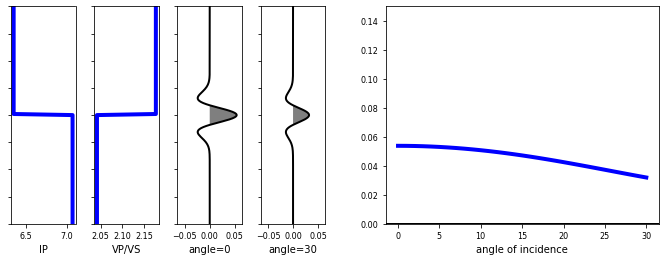

In [7]:
twolayer(vp0_mean, vs0_mean, rho0_mean, vp1_mean, vs1_mean, rho1_mean)

In [8]:
def kde_resample(df, col, lithologies, logs,  num_samples=1000):
    """
    Resample from each litho-facies a set number of times
    Inputs:
    df: well data in pandas dataframe with column of litho-facies and columns of Vp, Vs and rho logs
    col: column containing the litho-facies categories
    lithologies: the categories (could use column and .unique() instead of input list)
    logs: list of column names of Vp, Vs, rho (e.g. 'RHOB' or 'DEN', etc)
    num_samples: number of resamples from gaussian_kde.resample()
    """
    
    kde_resample_array = [0] * len(lithologies)
    
    for i in range(len(lithologies)):
        lith_logs = df[df[col]==lithologies[i]][logs[0]],\
                        df[df[col]==lithologies[i]][logs[1]],\
                        df[df[col]==lithologies[i]][logs[2]]
        # reset_index() ??
        kde_lith_logs = gaussian_kde(lith_logs)
        kde_resample_array[i] = kde_lith_logs.resample(num_samples)
            
    return kde_resample_array

In [9]:
column = 'LABELS'
lith_list = ['shale', 'sltShale', 'clnSand', 'sltSand1', 'sltSand2', 'cemSand']
logs = ['VP', 'VS', 'RHOB']
num_samples = 1000

kde = kde_resample(well2, column, lith_list, logs, num_samples=1000)

In [10]:
# kde[0]=='shale', kde[1]=='sltShale', kde[2]=='clnSand', kde[3]. kde[4], kde[5]
# kde[.][0]=='VP', kde[.][1]=='VS', kde[.][2]=='RHOB'
# Assumes that cap rock is in position 0

#                                r0g(vp0      , vs0      , rho0     , vp1      , vs1      , rho1)
r01_b, G1_b, Rtheta1_b, med1_b = r0g(kde[0][0], kde[0][1], kde[0][2], kde[1][0], kde[1][1], kde[1][2])
r02_b, G2_b, Rtheta2_b, med2_b = r0g(kde[0][0], kde[0][1], kde[0][2], kde[2][0], kde[2][1], kde[2][2])
r03_b, G3_b, Rtheta3_b, med3_b = r0g(kde[0][0], kde[0][1], kde[0][2], kde[3][0], kde[3][1], kde[3][2])
r04_b, G4_b, Rtheta4_b, med4_b = r0g(kde[0][0], kde[0][1], kde[0][2], kde[4][0], kde[4][1], kde[4][2])
r05_b, G5_b, Rtheta5_b, med5_b = r0g(kde[0][0], kde[0][1], kde[0][2], kde[5][0], kde[5][1], kde[5][2])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


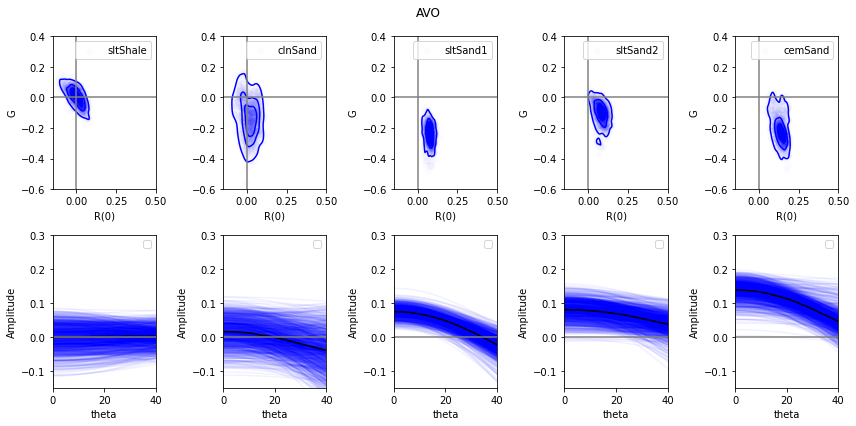

In [11]:
alpha1=0.01
alpha2=0.05

fig, ((ax1, ax2, ax3, ax4,ax5),(ax6,ax7,ax8,ax9,ax10)) = plt.subplots(2, 5, figsize=(12,6))
fig.suptitle('AVO')

ax1.scatter(r01_b, G1_b, label="sltShale", alpha=alpha1, color='blue')
sns.kdeplot(ax=ax1, x=r01_b, y=G1_b, color='blue', linestyles="-", levels=4)
ax1.set_xlabel("R(0)"); ax1.set_ylabel("G")

ax2.scatter(r02_b, G2_b, label="clnSand", alpha=alpha1, color='blue')
sns.kdeplot(ax=ax2, x=r02_b, y=G2_b, color="blue", linestyles="-", levels=4)
ax2.set_xlabel("R(0)"); ax3.set_ylabel("G")

ax3.scatter(r03_b, G3_b, label="sltSand1", alpha=alpha1, color='blue')
sns.kdeplot(ax=ax3, x=r03_b, y=G3_b, color="blue", linestyles="-", levels=4)
ax3.set_xlabel("R(0)"); ax3.set_ylabel("G")

ax4.scatter(r04_b, G4_b, label="sltSand2", alpha=alpha1, color='blue')
sns.kdeplot(ax=ax4, x=r04_b, y=G4_b, color="blue", linestyles="-", levels=4)
ax4.set_xlabel("R(0)"); ax4.set_ylabel("G")

ax5.scatter(r05_b, G5_b, label="cemSand", alpha=alpha1, color='blue')
sns.kdeplot(ax=ax5, x=r05_b, y=G5_b, color="blue", linestyles="-", levels=4)
ax5.set_xlabel("R(0)"); ax5.set_ylabel("G")

for i in range(num_samples):
    ax6.plot(Rtheta1_b[i][0], alpha=alpha2, color='blue')
ax6.plot(med1_b, 'k')
ax6.set_xlabel("theta"); ax6.set_ylabel("Amplitude")

for i in range(num_samples):
    ax7.plot(Rtheta2_b[i][0], alpha=alpha2, color='blue')
ax7.plot(med2_b, 'k')
ax7.set_xlabel("theta"); ax7.set_ylabel("Amplitude")

for i in range(num_samples):
    ax8.plot(Rtheta3_b[i][0], alpha=alpha2, color='blue')
ax8.plot(med3_b, 'k')
ax8.set_xlabel("theta"); ax8.set_ylabel("Amplitude")

for i in range(num_samples):
    ax9.plot(Rtheta4_b[i][0], alpha=alpha2, color='blue')
ax9.plot(med4_b, 'k')
ax9.set_xlabel("theta"); ax9.set_ylabel("Amplitude")

for i in range(num_samples):
    ax10.plot(Rtheta5_b[i][0], alpha=alpha2, color='blue')
ax10.plot(med5_b, 'k')
ax10.set_xlabel("theta"); ax10.set_ylabel("Amplitude")



ax1.set_xlim(-0.15, 0.5); ax1.set_ylim(-0.6, 0.4);
ax2.set_xlim(-0.15, 0.5); ax2.set_ylim(-0.6, 0.4); 
ax3.set_xlim(-0.15, 0.5); ax3.set_ylim(-0.6, 0.4);
ax4.set_xlim(-0.15, 0.5); ax4.set_ylim(-0.6, 0.4);
ax5.set_xlim(-0.15, 0.5); ax5.set_ylim(-0.6, 0.4);

ax6.set_xlim(0,40); ax6.set_ylim(-0.15, 0.3);
ax7.set_xlim(0,40); ax7.set_ylim(-0.15, 0.3);
ax8.set_xlim(0,40); ax8.set_ylim(-0.15, 0.3);
ax9.set_xlim(0,40); ax9.set_ylim(-0.15, 0.3);
ax10.set_xlim(0,40); ax10.set_ylim(-0.15, 0.3);


for ax in fig.get_axes():
    ax.legend()
    #ax.label_outer()
    ax.axvline(0, color='gray')
    ax.axhline(0, color='gray')
    
plt.tight_layout()

#plt.savefig("./images/R0_G_AVO_modeling.png")